# Neural Networks
Deeplearning is often utalised in fraud detection however due to the size of the data set and computational constraints training the network on every datapoint is impractical, As such this network will be train on a smaller sample of the dataset. This sample will include all fradulent cases but will downsample the number legitimate transactions to improve the class imbalance and training times

In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [2]:
nn_df = pd.read_csv('modeling_df.csv')
nn_df = nn_df.sort_values('trans_date_trans_time')

In [3]:
nn_df['trans_date_trans_time'] = pd.to_datetime(nn_df['trans_date_trans_time'], errors="coerce")

Split the dataset into train, validation and test sets

In [4]:
# Train -> 70%, val ->15% and test ->15
t1 = nn_df['trans_date_trans_time'].quantile(0.7)
t2 = nn_df['trans_date_trans_time'].quantile(0.85)

train_df = nn_df[nn_df['trans_date_trans_time'] < t1]
val_df = nn_df[(nn_df['trans_date_trans_time'] > t1) & (nn_df['trans_date_trans_time'] < t2)]
test_df = nn_df[nn_df['trans_date_trans_time'] > t2]

### DownSampling
To implement our sampling method we will down sample the majority class (non-fraud). This both reduces the size of the dataset (improving training time) and evens out the class imbalance. the temporal_downsample function is used to achieve this. This function bins transactions by a timeframe i.e. one month. Within that month we keep all the fradulent transaction and sample x number of non-fradulent cases from a similar time frame (this number is determined by the parameter keep_ratio)

In [5]:
def temporal_downsample(frame, keep_ratio=0.3, time_col='trans_date_trans_time', y_col='is_fraud', freq='M', random_state=42):
    rng = np.random.default_rng(random_state)
    frame = frame.copy()
    frame['bin'] = frame[time_col].dt.to_period(freq).dt.to_timestamp()

    fraud = frame[frame[y_col] == 1]
    non  = frame[frame[y_col] == 0]

    # Loop through each time bin and add non-fraudulent cases into a list
    sampled_non_list = []
    for b, chunk in non.groupby('bin', sort=False):
        n = int(np.ceil(len(chunk) * keep_ratio))
        if n <= 0: 
            continue
        sampled_non_list.append(chunk.sample(n=n, random_state=int(rng.integers(1_000_000))))

    # Concat sampled cases and fraud
    sampled_non = pd.concat(sampled_non_list, axis=0) if sampled_non_list else non.iloc[0:0]
    out = pd.concat([fraud, sampled_non], axis=0).drop(columns='bin')
    return shuffle(out, random_state=random_state)

train_ds = temporal_downsample(train_df, keep_ratio=0.3, freq='M')
val_ds   = val_df  # we do not need to downsample validation/test
test_ds  = test_df

Finalise training, val and test sets using our sampling function

In [6]:
print(test_df.columns)
test_df = test_df.drop(columns=['trans_date_trans_time', 'cc_num'], axis=1)
val_df = val_df.drop(columns=['trans_date_trans_time', 'cc_num'], axis=1)
train_df = train_df.drop(columns=['trans_date_trans_time', 'cc_num'], axis=1)

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'is_fraud',
       'trans_hour', 'time_since_last', 'last_amt'],
      dtype='object')


The neural network will be trained on the same feature set as our XGboost model" ['catagory', 'amt', 'trans_hour', 'time_since_last','last_amt'] and the dependent will remain 'is_fraud' a binary lable for fraud

In [7]:
X_test = test_df.drop(columns=['is_fraud'], axis=1)
y_test = test_df['is_fraud']

X_val = val_df.drop(columns=['is_fraud'], axis=1)
y_val = val_df['is_fraud']

X_train = train_df.drop(columns=['is_fraud'], axis=1)
y_train = train_df['is_fraud']


# Fiting the pipeline
num_feat = ['amt', 'trans_hour', 'time_since_last','last_amt']
cat_feat = ['category']

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

Preprocessor = ColumnTransformer([
    ('num', num_transformer, num_feat),
    ('cat', cat_transformer, cat_feat)
])


In [8]:
X_train_p = Preprocessor.fit_transform(X_train)
X_val_p   = Preprocessor.transform(X_val)
X_test_p  = Preprocessor.transform(X_test)

input_dim = X_train_p.shape[1]

### Neural Network
The make_model function will be used to create a neural network. The network will consist of a number of layers defined by the 'layers' parameter and will utalise a relu activation. The final output layer will be a single node with a sigmoid activation to output a probability

In [9]:
def make_model(input_dim, layers=[128,64], dropout=0.2, lr=3e-3):
    keras.utils.set_random_seed(64)
    input_layer = keras.Input(shape=(input_dim,))
    x = input_layer

    for h in layers:
        x = keras.layers.Dense(h, activation='relu')(x)
        x = keras.layers.Dropout(dropout)(x)

    out = keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = keras.Model(input_layer, out)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc'), keras.metrics.Precision(), keras.metrics.Recall()])
    return model

Fit an inital model to our data

In [32]:

model = make_model(input_dim)
cb = [keras.callbacks.EarlyStopping(patience=5, 
                                    restore_best_weights=True, 
                                    monitor='val_auc', 
                                    mode='max')]

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=50, batch_size=2048,
    callbacks=cb, verbose=1
)

Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc: 0.9047 - loss: 0.0220 - precision: 0.8426 - recall: 0.4027 - val_auc: 0.9400 - val_loss: 0.0088 - val_precision: 0.9533 - val_recall: 0.6020
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc: 0.9587 - loss: 0.0099 - precision: 0.9198 - recall: 0.6241 - val_auc: 0.9613 - val_loss: 0.0068 - val_precision: 0.9495 - val_recall: 0.6462
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc: 0.9717 - loss: 0.0081 - precision: 0.9208 - recall: 0.6811 - val_auc: 0.9670 - val_loss: 0.0058 - val_precision: 0.9297 - val_recall: 0.7035
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc: 0.9764 - loss: 0.0072 - precision: 0.9245 - recall: 0.7118 - val_auc: 0.9681 - val_loss: 0.0054 - val_precision: 0.9354 - val_recall: 0.7002
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.9787 - loss: 0.0067 - precision: 0.9281 - recall: 0.7264 - val_auc: 0.9790 - val_loss: 0.0051 - val_precision: 0.9284 - val_recall: 0.7224


Model Evaluation

In [33]:
print("Test metrics:", model.evaluate(X_test_p, y_test, verbose=0))

thr = 0.50
# Probabilities on test
y_prob = model.predict(X_test_p, batch_size=4096, verbose=0).ravel()

# Binary predictions
y_pred = (y_prob >= thr).astype(int)
# Counts
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Confusion matrix (counts) [rows=true, cols=pred]:\n", cm)


Test metrics: [0.0035184170119464397, 0.9874017834663391, 0.8508968353271484, 0.8214285969734192]
Confusion matrix (counts) [rows=true, cols=pred]:
 [[276801    133]
 [   165    759]]


### Hyper parameter optimisation
Next we will run a grid search using our training and validation sets to optimise the network structure

In [34]:
search_space = {
    "hidden_layers": [[256,128], [128,64], [256,128,64], [256,128,64,64]],
    "dropout": [0.1, 0.2, 0.3],
    "lr": [1e-3, 3e-3, 1e-4],
    "batch_size": [1024, 2048, 4096]
}


import random

def sample_cfg(space):
    return {
        "hidden": random.choice(space["hidden_layers"]),
        "dropout": random.choice(space["dropout"]),
        "lr": random.choice(space["lr"]),
        "batch_size": random.choice(space["batch_size"])
    }

def train_eval(cfg):
    m = make_model(input_dim, layers=cfg["hidden"], dropout=cfg["dropout"], lr=cfg["lr"])
    h = m.fit(
        X_train_p, y_train,
        validation_data=(X_val_p, y_val),
        epochs=40,
        batch_size=cfg["batch_size"],
        callbacks=[keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_auc', mode='max')],
        verbose=0
    )
    best_auc = max(h.history['val_auc'])
    return m, best_auc


# Track the best result
best_auc, best_model, best_cfg = -np.inf, None, None

# Track seen configs
seen = set()

for i in range(12):
    while True:
        cfg = sample_cfg(search_space)
        key = tuple((k, tuple(cfg[k]) if isinstance(cfg[k], list) else cfg[k]) 
                    for k in sorted(cfg))
        if key not in seen:
            seen.add(key)
            break

    model_i, auc_i = train_eval(cfg)

    if auc_i > best_auc:
        best_auc, best_model, best_cfg = auc_i, model_i, cfg
        print(f"[{i}] New best AUC={auc_i:.4f} with {cfg}")

print("Best config:", best_cfg, "Val AUC:", best_auc)
print("Test metrics:", best_model.evaluate(X_test_p, y_test, verbose=0))

[0] New best AUC=0.9881 with {'hidden': [256, 128], 'dropout': 0.1, 'lr': 0.003, 'batch_size': 4096}
[2] New best AUC=0.9907 with {'hidden': [256, 128], 'dropout': 0.2, 'lr': 0.003, 'batch_size': 1024}
[4] New best AUC=0.9909 with {'hidden': [256, 128], 'dropout': 0.3, 'lr': 0.003, 'batch_size': 1024}
[6] New best AUC=0.9922 with {'hidden': [256, 128, 64, 64], 'dropout': 0.1, 'lr': 0.003, 'batch_size': 4096}
[10] New best AUC=0.9928 with {'hidden': [256, 128, 64, 64], 'dropout': 0.3, 'lr': 0.001, 'batch_size': 1024}
Best config: {'hidden': [256, 128, 64, 64], 'dropout': 0.3, 'lr': 0.001, 'batch_size': 1024} Val AUC: 0.9928497076034546
Test metrics: [0.003952055238187313, 0.9881848692893982, 0.8173912763595581, 0.8138527870178223]


Evaluating the best network

In [41]:
y_prob = best_model.predict(X_test_p, batch_size=4096, verbose=0).ravel()

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix (rows=true, cols=pred):")
print(cm)
print(f"\nTN={TN}, FP={FP}, FN={FN}, TP={TP}")

Confusion Matrix (rows=true, cols=pred):
[[276766    168]
 [   172    752]]

TN=276766, FP=168, FN=172, TP=752


# Increasing fraud weight
Our first attempts at training a neural network have had moderate success however is still struggling to classify our fradulent cases. As such we will increase the loss of fraud missclassification. The training data will remain downsampled using the function created earlier and will contain the same features ['catagory', 'amt', 'trans_hour', 'time_since_last','last_amt']


In [64]:
# 3 with class weighte loss
# Compute class weights from the training dataset
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0,1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
class_weight


{0: 0.5029076802785043, 1: 86.47919167667067}

In [65]:
# Fitting model with class weights
imb_model = make_model(input_dim, layers=[256,128], dropout=0.2, lr=3e-3)
hist = imb_model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=40, batch_size=2048,
    class_weight=class_weight,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc', mode='max')],
    verbose=1
)
print("Imbalance-weighted Test:", imb_model.evaluate(X_test_p, y_test, verbose=0))


Epoch 1/40
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - auc: 0.9828 - loss: 0.1641 - precision: 0.1005 - recall: 0.9286 - val_auc: 0.9943 - val_loss: 0.0865 - val_precision: 0.1405 - val_recall: 0.9353
Epoch 2/40
634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - auc: 0.9940 - loss: 0.0956 - precision: 0.1502 - recall: 0.9589 - val_auc: 0.9963 - val_loss: 0.0755 - val_precision: 0.1339 - val_recall: 0.9607
Epoch 3/40
634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - auc: 0.9956 - loss: 0.0815 - precision: 0.1632 - recall: 0.9653 - val_auc: 0.9968 - val_loss: 0.0632 - val_precision: 0.1650 - val_recall: 0.9615
Epoch 4/40
634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - auc: 0.9962 - loss: 0.0750 - precision: 0.1752 - recall: 0.9683 - val_auc: 0.9968 - val_loss: 0.0708 - val_precision: 0.1405 - val_recall: 0.9689
Epoch 5/40
634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - auc: 0.9966 - loss: 0.0716 - precision: 0.1775 - recall: 0.9689 - val_auc: 0.9971 - val_loss: 0.0627 - val_precision: 0.1601 - val_recall: 0

Model Evaluation

In [83]:
probs_test = imb_model.predict(X_test_p, verbose=0).ravel()
y_pred_05 = (probs_test >= 0.5).astype(int)

cm_05 = confusion_matrix(y_test, y_pred_05, labels=[0,1])  # rows = true [0,1], cols = pred [0,1]
tn, fp, fn, tp = cm_05.ravel()
print("Confusion matrix @0.5 (rows=true, cols=pred):\n", cm_05)
print(pd.DataFrame(cm_05, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}\n")
print(classification_report(y_test, y_pred_05, digits=4))


Confusion matrix @0.5 (rows=true, cols=pred):
 [[272168   4766]
 [    29    895]]
        Pred 0  Pred 1
True 0  272168    4766
True 1      29     895
TN=272168  FP=4766  FN=29  TP=895

              precision    recall  f1-score   support

           0     0.9999    0.9828    0.9913    276934
           1     0.1581    0.9686    0.2718       924

    accuracy                         0.9827    277858
   macro avg     0.5790    0.9757    0.6315    277858
weighted avg     0.9971    0.9827    0.9889    277858



### Optimising decision threshold
Increasing the weight/ loss for missclassifying fraud has significantly improved the models true positive rate. By plotting the recall, precision and f1 score at different classification thresholds we can further optimise our model

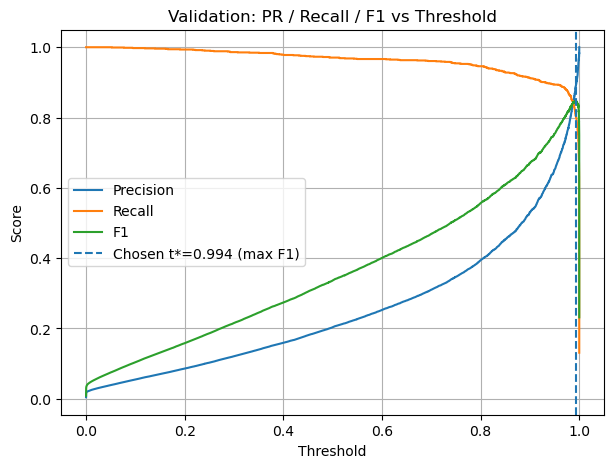

[Validation] t*=0.9944 | F1=0.8465 | Precision=0.9026 | Recall=0.7969


In [84]:
probs_val  = imb_model.predict(X_val_p,  verbose=0).ravel()   # validation probs (fraud class)
probs_test = imb_model.predict(X_test_p, verbose=0).ravel()   # test probs (fraud class)

prec_v, rec_v, thr_v = precision_recall_curve(y_val, probs_val)
f1_v = 2 * prec_v * rec_v / (prec_v + rec_v + 1e-8)

best_idx = int(np.nanargmax(f1_v))
t_star   = float(thr_v[min(best_idx, len(thr_v)-1)])

plt.figure(figsize=(7,5))
plt.plot(thr_v, prec_v[:-1], label='Precision')
plt.plot(thr_v, rec_v[:-1],  label='Recall')
plt.plot(thr_v, f1_v[:-1],   label='F1')
plt.axvline(t_star, ls='--', label=f'Chosen t*={t_star:.3f} (max F1)')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Validation: PR / Recall / F1 vs Threshold')
plt.grid(True); plt.legend(); plt.show()

print(f"[Validation] t*={t_star:.4f} | "
      f"F1={f1_v[best_idx]:.4f} | Precision={prec_v[best_idx]:.4f} | Recall={rec_v[best_idx]:.4f}")


### Getting validation metrics at optimal f1 threshold

In [85]:

y_test_pred = (probs_test >= t_star).astype(int)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_test, probs_test)
ap_te   = average_precision_score(y_test, probs_test)

print("\n[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, digits=4))


[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):
[[276809    125]
 [   169    755]]
TN=276809, FP=125, FN=169, TP=755
Precision=0.8580 | Recall=0.8171 | F1=0.8370 | ROC AUC=0.9980 | PR AUC=0.8906

Classification report:
              precision    recall  f1-score   support

           0     0.9994    0.9995    0.9995    276934
           1     0.8580    0.8171    0.8370       924

    accuracy                         0.9989    277858
   macro avg     0.9287    0.9083    0.9182    277858
weighted avg     0.9989    0.9989    0.9989    277858



From the curve we see a sharp drop in recall near the 0.95 threshold. As such to improve upon fraud detection we will evaluate peformance on a lower threshold to boost recall 

In [93]:
### trying 0.8
y_test_pred = (probs_test >= 0.8).astype(int)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_test, probs_test)
ap_te   = average_precision_score(y_test, probs_test)

print("\n[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, digits=4))


[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):
[[275075   1859]
 [    50    874]]
TN=275075, FP=1859, FN=50, TP=874
Precision=0.3198 | Recall=0.9459 | F1=0.4780 | ROC AUC=0.9980 | PR AUC=0.8906

Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9933    0.9965    276934
           1     0.3198    0.9459    0.4780       924

    accuracy                         0.9931    277858
   macro avg     0.6598    0.9696    0.7373    277858
weighted avg     0.9976    0.9931    0.9948    277858



### Plotting ROC and precision-Recall curves

In [26]:
from sklearn.metrics import roc_curve

def plot_pr_with_point(y, p, t_star=None, title="Precision–Recall Curve"):
    prec, rec, thr = precision_recall_curve(y, p)
    pr_auc = average_precision_score(y, p)

    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.4f}")
    if t_star is not None:
        # find the nearest threshold index to t_star
        j = np.searchsorted(thr, t_star, side="left")
        j = np.clip(j, 0, len(prec)-1)  # align to PR arrays
        plt.scatter(rec[j], prec[j], s=60, marker='o', label=f"@ t*={t_star:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()
    return pr_auc

def plot_roc_with_point(y, p, t_star=None, title="ROC Curve"):
    fpr, tpr, thr = roc_curve(y, p)
    rocA = roc_auc_score(y, p)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {rocA:.4f}")
    plt.plot([0,1],[0,1], ls="--", c="gray")
    if t_star is not None:
        j = np.searchsorted(thr[::-1], t_star, side="left")
        jj = len(thr) - 1 - np.clip(j, 0, len(thr)-1)
        jj = np.clip(jj, 0, len(fpr)-1)
        plt.scatter(fpr[jj], tpr[jj], s=60, marker='o', label=f"@ t*={t_star:.3f}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()
    return rocA

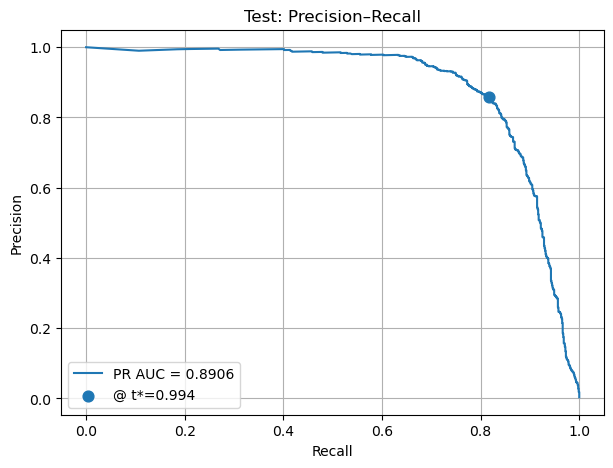

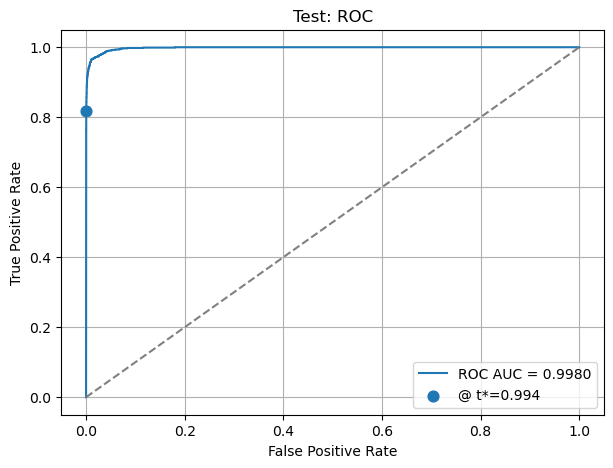

In [97]:
pr_auc_test  = plot_pr_with_point(y_test,  probs_test, t_star=0.9944 , title="Test: Precision–Recall")
roc_auc_test = plot_roc_with_point(y_test, probs_test, t_star=0.9944 , title="Test: ROC")


# Oversampling minority
To improve upon fraud detection we will experiment with over sampling the minority class. To achieve this the oversample_minority_for_training will oversample fraudulent cases and undersample non-fraud cases to reach a chosen ratio e.g 1:4.
To acheve this we will sample with replacement our fradulent cases and undersmaple our legitamate transactions. (similar to downsampling but we increase the number of fradulent transactions through sampling with replacement)


In [39]:
# Simple oversample minority (with replacement) + undersample non-fraud to target_ratio (e.g., 1:4)

def oversample_minority_for_training(frame, y_col='is_fraud', target_neg_pos_ratio=4, random_state=123):
    rng = np.random.default_rng(random_state)
    fraud = frame[frame[y_col] == 1]
    non   = frame[frame[y_col] == 0]

    # keep all fraud and draw enough non-fraud to match target ratio
    n_pos = len(fraud)
    n_neg = min(len(non), target_neg_pos_ratio * n_pos)
    non_sampled = non.sample(n=n_neg, random_state=int(rng.integers(1_000_000)))

    dup_factor = max(1, (n_neg // target_neg_pos_ratio) // max(1, n_pos))
    fraud_oversampled = pd.concat([fraud] * dup_factor, axis=0)

    return shuffle(pd.concat([fraud_oversampled, non_sampled], axis=0), random_state=random_state)

train_bal = oversample_minority_for_training(train_df, target_neg_pos_ratio=4)

Xb = train_bal.drop(columns=['is_fraud'], errors='ignore')
print(Xb.columns)
yb = train_bal['is_fraud'].astype(int)

Xb_p = Preprocessor.fit_transform(Xb)
Xv_p = Preprocessor.transform(X_val)
Xt_p = Preprocessor.transform(X_test)

bal_model = make_model(Xb_p.shape[1], layers=[256,128], dropout=0.2, lr=3e-3)
bal_model.fit(
    Xb_p, yb,
    validation_data=(Xv_p, y_val),
    epochs=40, batch_size=2048,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc', mode='max')],
    verbose=1
)
print("Balanced-batch Test:", bal_model.evaluate(Xt_p, y_test, verbose=0))


Index(['category', 'amt', 'trans_hour', 'time_since_last', 'last_amt'], dtype='object')
Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8942 - loss: 0.3053 - precision_14: 0.8821 - recall_14: 0.6584 - val_auc: 0.9227 - val_loss: 0.1267 - val_precision_14: 0.1072 - val_recall_14: 0.8051
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9498 - loss: 0.1922 - precision_14: 0.9023 - recall_14: 0.8011 - val_auc: 0.9554 - val_loss: 0.0764 - val_precision_14: 0.1752 - val_recall_14: 0.8067
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9653 - loss: 0.1592 - precision_14: 0.9165 - recall_14: 0.8407 - val_auc: 0.9712 - val_loss: 0.0642 - val_precision_14: 0.1938 - val_recall_14: 0.8329
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9738 - loss: 0.1386 - precision_14: 0.9264 - recall_14: 0.8558 - val_auc: 0.9773 - val_loss: 0.0521 - val_precision_14: 0.2189 - val_recall_14: 0.8468
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9794 - l

Model evaluation

In [40]:
# Confusion matrix for the balanced-batch model (default threshold = 0.5)
print("Test metrics:", bal_model.evaluate(Xt_p, y_test, verbose=0))
from sklearn.metrics import classification_report

y_pred = (bal_model.predict(Xt_p) > 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(
    y_test,
    (bal_model.predict(Xt_p, verbose=0).ravel() >= 0.5).astype(int),
    labels=[0, 1]
)
print(cm)  # [[TN, FP],

[[274872   2062]
 [    60    864]]


# LSTM

Analysis reveals significant time related dependencies in classifying fraud. One such example is 'burst transactions' multiple transactions in a short stretch of time (ussually a smaller amount followed by a larger one) being a strong indicator of fraud. Engineered features such as 'time_since_last' and 'last_amt' attempt to model these dependencies within previous models however the strengths of an LSTM are that it can capture such time dependencies. As such an LSTM could be a good fit for our dataset. This model will use the same features as the previous neural networks: ['category', 'amt', 'trans_hour', 'time_since_last', 'last_amt'], with the dependent remaining 'is_fraud'

In [6]:
print(nn_df.columns)
LSTM_df = nn_df

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'is_fraud',
       'trans_hour', 'time_since_last', 'last_amt'],
      dtype='object')


In [2]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.utils.extmath import softmax
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Date Preperation: 
To prep the data for LSTM training we will create a pipeline, split the dataset into test, validation and training sets and finally split the data into windows

In [8]:
# Data preperation:
num_feats = ['amt', 'trans_hour', 'time_since_last', 'last_amt']
cat_feats = ['category']
features = num_feats + cat_feats

LSTM_num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

LSTM_cat_pipe = Pipeline([
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

Preporcessor = ColumnTransformer([
    ('num', LSTM_num_pipe, num_feats),
    ('cat', LSTM_cat_pipe, cat_feats)
])


In [9]:
LSTM_df.sort_values(['cc_num','trans_date_trans_time'], inplace=True)
LSTM_df.reset_index(drop=True, inplace=True)

In [10]:
# Getting train/ test splits
n = len(LSTM_df)
x = int(0.7 * n)    # 70% mark
i = int(0.85 * n)   # 85% mark

train_LSTM = LSTM_df.iloc[:x]
val_LSTM = LSTM_df.iloc[x:i]
test_LSTM = LSTM_df.iloc[i:]

y_train_LSTM = train_LSTM['is_fraud'].to_numpy().astype(int)
y_val_LSTM   = val_LSTM['is_fraud'].to_numpy().astype(int)
y_test_LSTM  = test_LSTM['is_fraud'].to_numpy().astype(int)

id_train = train_LSTM['cc_num'].to_numpy()
id_val   = val_LSTM['cc_num'].to_numpy()
id_test  = test_LSTM['cc_num'].to_numpy()

t_train = train_LSTM['trans_date_trans_time']
t_val   = val_LSTM['trans_date_trans_time']
t_test  = test_LSTM['trans_date_trans_time']

In [11]:
# Transform Data using pipelines
LSTM_train = Preporcessor.fit_transform(train_LSTM[features])
LSTM_val = Preporcessor.transform(val_LSTM[features])
LSTM_test = Preporcessor.transform(test_LSTM[features])

We next create our function to build the windows needed to train our model.
The build_windows_by_group function first groups each transaction by card number and sorts by the transaction date. To build each window it then slides a fixed-size window (set by lookback) across the grouped transactions to capture recent transaction history.
Each window becomes one training sample and the label is the target value (e.g. fraud) of the last transaction in that window.
Example - say we have already grouped the dataset by card number and sorted by date
- [card_number, feature, is_fraud]
- [1, x1, 0]
- [1, x2, 0]
- [1, x3, 1]
- [1, x4, 0]
- The first window is [x1, x2, x3] and its lable is y=1 as the last transaction is fradulent.
- the second window (sliding over by 1) is [x2, x3, x4] and its lable is y=0
- so the y array becomes [1,0] for our example

In [12]:
def build_windows_by_group(X_rows, y_rows, group_ids, times, lookback=64, stride=1):
    """
    Returns:
      X_seq: (Nw, T, F)
      y_seq: (Nw,)
    """

    #idx gets the original index
    idx = np.arange(len(y_rows))
    order_df = pd.DataFrame({'i': idx, 'id': group_ids, 't': pd.to_datetime(times)})
    order_df.sort_values(['id','t'], kind='mergesort', inplace=True)

    Xs, ys = [], []

    # for each id we create a block i.e. a list of global indicies for all the same transactions 
    for g, block in order_df.groupby('id', sort=False):
        I = block['i'].to_numpy()
        n = len(I)
        if n < lookback:
            continue
        # slide the window across the block by 'stride' and appending the features and y lable to Xs and ys
        for stop in range(lookback, n+1, stride):
            win_idx = I[stop-lookback:stop]
            Xs.append(X_rows[win_idx])
            ys.append(y_rows[win_idx[-1]])  # label = last row in window
    return np.asarray(Xs), np.asarray(ys).astype(int)


In [13]:
# Baseline model
# Note due to the size of the dataset I had to decrease the size of the windows and strides
# Number of transactions a window contains
Lookback = 32
# How far each window slides
Stride = 2


# Build training window
X_tr_seq, y_tr_seq = build_windows_by_group(LSTM_train, y_train_LSTM, id_train, t_train,
                                            lookback=Lookback, stride=Stride)
X_va_seq, y_va_seq = build_windows_by_group(LSTM_val,   y_val_LSTM,   id_val,   t_val,
                                            lookback=Lookback, stride=Stride)
X_te_seq, y_te_seq = build_windows_by_group(LSTM_test,  y_test_LSTM,  id_test,  t_test,
                                            lookback=Lookback, stride=Stride)



In [ ]:
# Saving testing data - will be used to test if fastAPI works for deployability

import json

N, T, F = X_te_seq.shape  # e.g., (num_windows, timesteps, features)
print(N, T, F)

windows_json = [json.dumps(win.tolist()) for win in X_te_seq]
df_json = pd.DataFrame({"window": windows_json, "is_fraud": y_te_seq.astype(int)})
df_json.to_csv("test_windows_json.csv", index=False)
print("Wrote data/test_windows_json.csv")


136737 32 17


This next function converts the input data into TensorFlow datasets for efficient model training

In [18]:
def make_ds(X, y, batch_size=256, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(y), 8192), seed=123)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
BATCH = 256
ds_tr = make_ds(X_tr_seq, y_tr_seq, batch_size=BATCH, shuffle=True)
ds_va = make_ds(X_va_seq, y_va_seq, batch_size=BATCH, shuffle=False)
ds_te = make_ds(X_te_seq, y_te_seq, batch_size=BATCH, shuffle=False)

### Building LSTM model

This next function is used to build our LSTM models. The number of LSTM layers is set by the lstm_units input, The second-last layer is a dense (fully connected) layer with a ReLU activation and the final output layers uses a sigmoid activation to output a probability

In [29]:
def build_lstm(timesteps, n_features, lstm_units=[128,64], dense_units=64, dropout=0.3, lr=1e-3):
    inputs = keras.Input(shape=(timesteps, n_features))
    # Sometimes your sequences aren’t all the same length. To feed them to a model, you pad the shorter ones with a filler value
    x = layers.Masking(mask_value=0.0)(inputs)

    
    for i, n in enumerate(lstm_units):
        return_seq = (i < len(lstm_units) - 1)
        x = layers.LSTM(n, return_sequences=return_seq )(x)
        x = layers.Dropout(dropout)(x)
        

    x = layers.Dense(dense_units, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs,out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="AUC"),
            keras.metrics.Precision(name="Precision"),
            keras.metrics.Recall(name="Recall"),
        ],
    )
    return model

Training the model

In [30]:
timesteps = X_tr_seq.shape[1]
n_features = X_tr_seq.shape[2]

model = build_lstm(timesteps, n_features)
es  = keras.callbacks.EarlyStopping(monitor="val_AUC", mode="max", patience=8, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_AUC", mode="max", factor=0.5, patience=4, min_lr=1e-5)

history = model.fit(
    ds_tr,
    validation_data=ds_va,
    epochs=50,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 235s 90ms/step - AUC: 0.9397 - Precision: 0.7427 - Recall: 0.5690 - loss: 0.0122 - val_AUC: 0.9767 - val_Precision: 0.9431 - val_Recall: 0.7532 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 241s 97ms/step - AUC: 0.9737 - Precision: 0.9279 - Recall: 0.7788 - loss: 0.0053 - val_AUC: 0.9770 - val_Precision: 0.9776 - val_Recall: 0.8506 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 225s 90ms/step - AUC: 0.9762 - Precision: 0.9539 - Recall: 0.8507 - loss: 0.0040 - val_AUC: 0.9739 - val_Precision: 0.9745 - val_Recall: 0.8669 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 226s 91ms/step - AUC: 0.9792 - Precision: 0.9550 - Recall: 0.8724 - loss: 0.0034 - val_AUC: 0.9732 - val_Precision: 0.9839 - val_Recall: 0.8945 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 5/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 232s 93ms/step - AUC: 0.9824 - Precision: 

In [55]:
from tensorflow import keras

# Saving the model so I don't have to retrain it
model.save("lstm_fraud_model.keras")

print("✅ Model saved successfully.")


✅ Model saved successfully.


In [19]:
from tensorflow import keras

model = keras.models.load_model("lstm_fraud_model.keras")
print("✅ Model loaded.")

# Predict directly
y_pred = model.predict(ds_te)


✅ Model loaded.
535/535 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step


### Model evaluation on 0.5 decision threshold

In [20]:
# model evaluation

# collect test labels
y_te_true = np.concatenate([y.numpy() for _, y in ds_te], axis=0)
# predict probabilities on test
y_te_prob = model.predict(ds_te, verbose=0).ravel()

y_te_pred = (y_te_prob >= 0.5).astype(int)


cm = confusion_matrix(y_te_true, y_te_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix [[TN, FP], [FN, TP]]:\n", cm)

print("\nAUC-ROC:", roc_auc_score(y_te_true, y_te_prob))
print("Average Precision (PR AUC):", average_precision_score(y_te_true, y_te_prob))
print("\nClassification report:\n", classification_report(y_te_true, y_te_pred, digits=4))
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Confusion matrix [[TN, FP], [FN, TP]]:
 [[136086     10]
 [    31    610]]

AUC-ROC: 0.9993088067044902
Average Precision (PR AUC): 0.9864528085449118

Classification report:
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998    136096
           1     0.9839    0.9516    0.9675       641

    accuracy                         0.9997    136737
   macro avg     0.9918    0.9758    0.9837    136737
weighted avg     0.9997    0.9997    0.9997    136737

TN=136086, FP=10, FN=31, TP=610


### Turning threshold
Next I will plot the Precision, Recall and F1 against the threshold to evaluate the best option

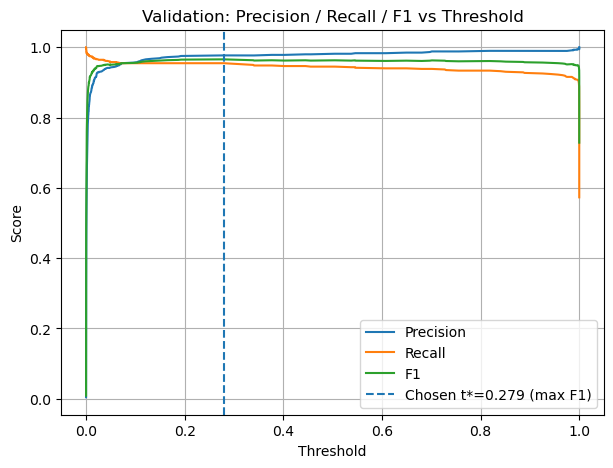

[Validation] t* (max-F1) = 0.2792 | F1=0.9655 | Precision=0.9767 | Recall=0.9545


In [21]:
# Collect validation labels and probabilities
y_va_true = np.concatenate([y.numpy() for _, y in ds_va], axis=0).ravel()
p_va      = model.predict(ds_va, verbose=0).ravel()   # P(fraud)


prec_va, rec_va, thr_va = precision_recall_curve(y_va_true, p_va)
f1_va = 2 * prec_va * rec_va / (prec_va + rec_va + 1e-8)

# Get threshold at best F1 score
best_idx_va = int(np.nanargmax(f1_va))
t_star      = float(thr_va[min(best_idx_va, len(thr_va)-1)])
best_f1_va  = float(f1_va[best_idx_va])

# Plot PR/F1 vs threshold
plt.figure(figsize=(7,5))
plt.plot(thr_va, prec_va[:-1], label='Precision')
plt.plot(thr_va, rec_va[:-1],  label='Recall')
plt.plot(thr_va, f1_va[:-1],   label='F1')
plt.axvline(t_star, ls='--', label=f'Chosen t*={t_star:.3f} (max F1)')
plt.xlabel('Threshold'); plt.ylabel('Score')
plt.title('Validation: Precision / Recall / F1 vs Threshold')
plt.grid(True); plt.legend(); plt.show()

print(f"[Validation] t* (max-F1) = {t_star:.4f} | F1={best_f1_va:.4f} | "
      f"Precision={prec_va[best_idx_va]:.4f} | Recall={rec_va[best_idx_va]:.4f}")

### Metrics and matrix at optimal threshold (test set)

In [22]:
y_te_true = np.concatenate([y.numpy() for _, y in ds_te], axis=0).ravel()
p_te      = model.predict(ds_te, verbose=0).ravel()

y_te_pred = (p_te >= t_star).astype(int)
cm = confusion_matrix(y_te_true, y_te_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_te_true, p_te)
ap_te   = average_precision_score(y_te_true, p_te)

print("\n[Test @ t*] Confusion matrix (rows: actual 0/1, cols: pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_te_true, y_te_pred, digits=4))


[Test @ t*] Confusion matrix (rows: actual 0/1, cols: pred 0/1):
[[136082     14]
 [    29    612]]
TN=136082, FP=14, FN=29, TP=612
Precision=0.9776 | Recall=0.9548 | F1=0.9661 | ROC AUC=0.9993 | PR AUC=0.9865

Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998    136096
           1     0.9776    0.9548    0.9661       641

    accuracy                         0.9997    136737
   macro avg     0.9887    0.9773    0.9830    136737
weighted avg     0.9997    0.9997    0.9997    136737



In [23]:
### Testing the threshold at 0.05
y_te_pred = (p_te >= 0.05).astype(int)
cm = confusion_matrix(y_te_true, y_te_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_te_true, p_te)
ap_te   = average_precision_score(y_te_true, p_te)

print("\n[Test @ t*] Confusion matrix (rows: actual 0/1, cols: pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_te_true, y_te_pred, digits=4))


[Test @ t*] Confusion matrix (rows: actual 0/1, cols: pred 0/1):
[[136048     48]
 [    22    619]]
TN=136048, FP=48, FN=22, TP=619
Precision=0.9280 | Recall=0.9657 | F1=0.9465 | ROC AUC=0.9993 | PR AUC=0.9865

Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997    136096
           1     0.9280    0.9657    0.9465       641

    accuracy                         0.9995    136737
   macro avg     0.9639    0.9827    0.9731    136737
weighted avg     0.9995    0.9995    0.9995    136737



### Plotting ROC and precision-Recall curves

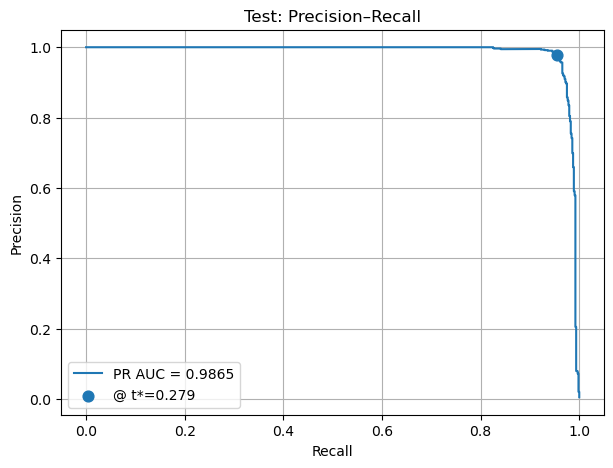

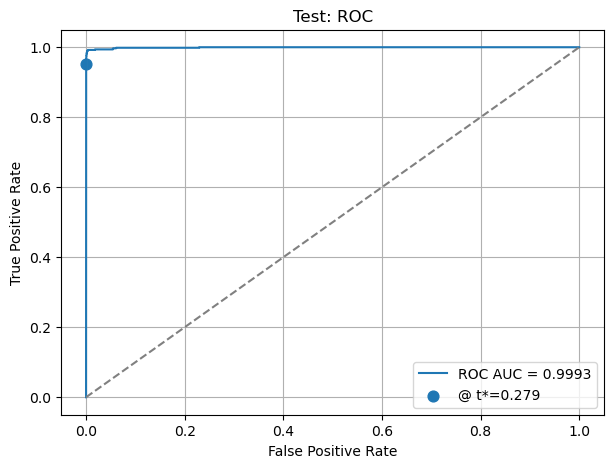

In [27]:

pr_auc_test  = plot_pr_with_point(y_te_true,  p_te, t_star=t_star , title="Test: Precision–Recall")
roc_auc_test = plot_roc_with_point(y_te_true, p_te, t_star=t_star , title="Test: ROC")


# Testing for overfitting

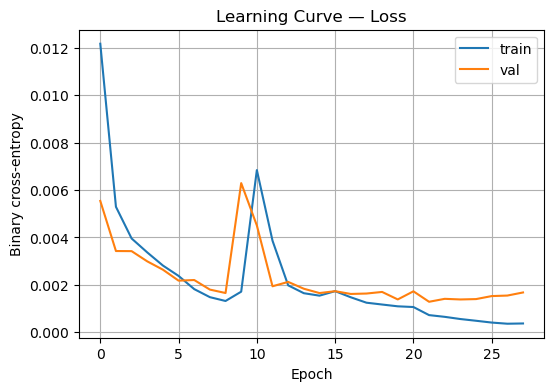

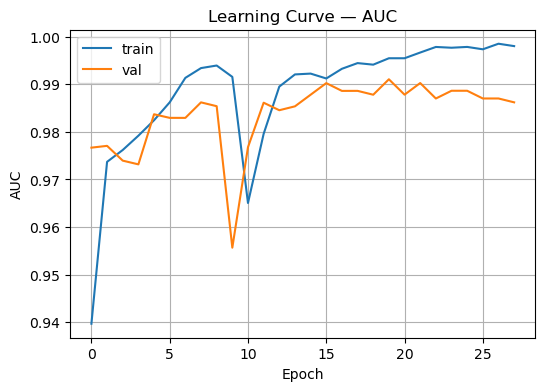

In [34]:
def plot_learning_curves(history):
    h = history.history
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h['loss'], label='train')
    plt.plot(h['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Binary cross-entropy')
    plt.title('Learning Curve — Loss'); plt.grid(True); plt.legend(); plt.show()


    if 'AUC' in h and 'val_AUC' in h:
        plt.figure(figsize=(6,4))
        plt.plot(h['AUC'], label='train')
        plt.plot(h['val_AUC'], label='val')
        plt.xlabel('Epoch'); plt.ylabel('AUC')
        plt.title('Learning Curve — AUC'); plt.grid(True); plt.legend(); plt.show()

plot_learning_curves(history)

In [31]:
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score, log_loss

# Collect labels & probabilities from datasets
def collect_labels_probs(ds, model):
    y = np.concatenate([y.numpy() for _, y in ds]).ravel()
    p = model.predict(ds, verbose=0).ravel()
    return y, p

y_tr, p_tr = collect_labels_probs(ds_tr, model)
y_va, p_va = collect_labels_probs(ds_va, model)
y_te, p_te = collect_labels_probs(ds_te, model)

def print_threshold_free(y, p, name):
    print(f"{name}:  PR-AUC={average_precision_score(y,p):.4f} | "
          f"ROC-AUC={roc_auc_score(y,p):.4f} | LogLoss={log_loss(y,p):.4f}")

print_threshold_free(y_va, p_va, "Validation")
print_threshold_free(y_te, p_te, "Test")


Validation:  PR-AUC=0.9835 | ROC-AUC=0.9993 | LogLoss=0.0014
Test:  PR-AUC=0.9869 | ROC-AUC=0.9995 | LogLoss=0.0013


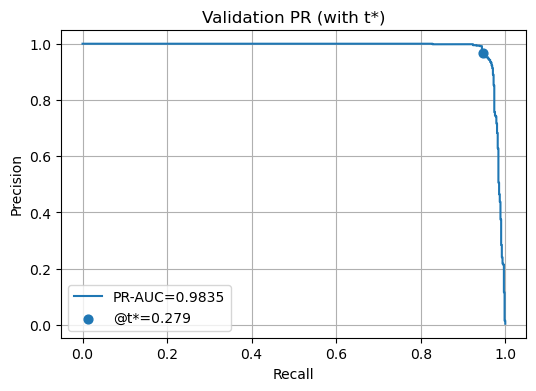

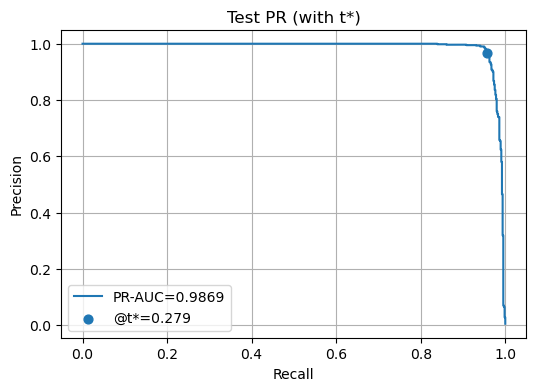

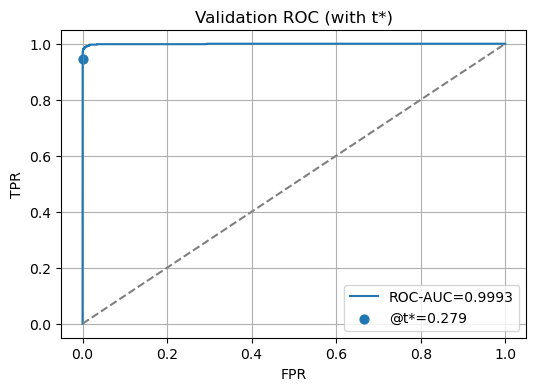

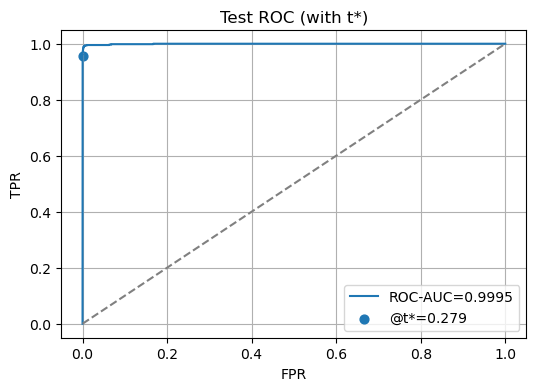

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

def plot_pr(y, p, t_star, title):
    prec, rec, thr = precision_recall_curve(y, p)
    prA = average_precision_score(y, p)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=f"PR-AUC={prA:.4f}")
    # mark t*
    j = np.searchsorted(thr, t_star, side="left")
    j = np.clip(j, 0, len(prec)-1)
    plt.scatter(rec[j], prec[j], s=40, label=f"@t*={t_star:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

def plot_roc(y, p, t_star, title):
    fpr, tpr, thr = roc_curve(y, p)
    rocA = roc_auc_score(y, p)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC-AUC={rocA:.4f}")
    plt.plot([0,1],[0,1], ls='--', c='gray')
    # thresholds are descending
    j = len(thr) - 1 - np.searchsorted(thr[::-1], t_star, side="left")
    j = np.clip(j, 0, len(fpr)-1)
    plt.scatter(fpr[j], tpr[j], s=40, label=f"@t*={t_star:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

plot_pr(y_va, p_va, t_star, "Validation PR (with t*)")
plot_pr(y_te, p_te, t_star, "Test PR (with t*)")
plot_roc(y_va, p_va, t_star, "Validation ROC (with t*)")
plot_roc(y_te, p_te, t_star, "Test ROC (with t*)")


In [33]:
# You already saved these:
# id_train, id_val, id_test = arrays of cc_num for each split (before windowing)

overlap_tv = set(id_train).intersection(set(id_val))
overlap_tt = set(id_train).intersection(set(id_test))
overlap_vt = set(id_val).intersection(set(id_test))

print(f"Overlapping IDs: train∩val={len(overlap_tv)}, train∩test={len(overlap_tt)}, val∩test={len(overlap_vt)}")
# If any are >0, consider re-splitting by customer so each ID lives in exactly one split.


Overlapping IDs: train∩val=1, train∩test=0, val∩test=1


In [35]:
import pickle

# Save training history
with open("lstm_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ Training history saved successfully.")


✅ Training history saved successfully.


In [ ]:
import pickle

# Load training history
with open("lstm_training_history.pkl", "rb") as f:
    history_dict = pickle.load(f)

# Recreate a dummy History-like object if needed
class DummyHistory:
    def __init__(self, hist):
        self.history = hist

history = DummyHistory(history_dict)
print("✅ Training history reloaded.")


# Undersampling

Next I will experiment with undersampling to address the class imbalance in the dataset, where non-fraudulent windows greatly outnumber fraudulent ones. This imbalance can cause the LSTM model to focus on predicting the majority class while ignoring the minority (fraud) cases.

The function works by keeping all positive (fraud) windows and randomly selecting a smaller subset of negative (non-fraud) windows at a chosen ratio (e.g., 1 fraud to 4 non-fraud). This creates a more balanced training dataset, allowing the model to better learn patterns associated with fraud while also reducing the total number of samples, improving training speed and efficiency.

In [57]:

def undersample_windows(X, y, target_neg_pos=4, seed=123):
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    if len(pos_idx) == 0:
        # no positives: keep a small random subset for a tiny baseline
        k = min(len(neg_idx), 10_000)
        keep = rng.choice(neg_idx, size=k, replace=False)
        return X[keep], y[keep], keep

    k_neg = min(len(neg_idx), target_neg_pos * len(pos_idx))
    keep_neg = rng.choice(neg_idx, size=k_neg, replace=False)

    keep = np.concatenate([pos_idx, keep_neg])
    rng.shuffle(keep)
    return X[keep], y[keep], keep


X_tr_bal, y_tr_bal, keep_idx = undersample_windows(X_tr_seq, y_tr_seq, target_neg_pos=4, seed=123)

# rebuild the training dataset with the undersampled windows
ds_tr = make_ds(X_tr_bal, y_tr_bal, batch_size=BATCH, shuffle=True)

print("Before:", X_tr_seq.shape, "After undersampling:", X_tr_bal.shape)


Before: (638332, 32, 17) After undersampling: (14965, 32, 17)


In [88]:
# Model training using undersampling

ds_tr = make_ds(X_tr_bal, y_tr_bal, batch_size=BATCH, shuffle=True)
tf.keras.backend.clear_session()

timesteps  = X_tr_bal.shape[1]
n_features = X_tr_bal.shape[2]

model = build_lstm(timesteps, n_features)  # uses your builder

es  = keras.callbacks.EarlyStopping(monitor="val_AUC", mode="max", patience=8, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_AUC", mode="max", factor=0.5, patience=4, min_lr=1e-5)

history = model.fit(
    ds_tr,
    validation_data=ds_va,
    epochs=50,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 838ms/step - AUC: 0.9040 - Precision: 0.8614 - Recall: 0.6813 - loss: 0.2781 - val_AUC: 0.9657 - val_Precision: 0.1711 - val_Recall: 0.8393 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 819ms/step - AUC: 0.9680 - Precision: 0.9341 - Recall: 0.8336 - loss: 0.1400 - val_AUC: 0.9741 - val_Precision: 0.1504 - val_Recall: 0.8847 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 828ms/step - AUC: 0.9761 - Precision: 0.9382 - Recall: 0.8677 - loss: 0.1183 - val_AUC: 0.9780 - val_Precision: 0.2647 - val_Recall: 0.8701 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 816ms/step - AUC: 0.9806 - Precision: 0.9421 - Recall: 0.8814 - loss: 0.1087 - val_AUC: 0.9794 - val_Precision: 0.1958 - val_Recall: 0.9188 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 806ms/step - AUC: 0.9832 - Precision: 0.9487 - Recall: 0.8

### Tuning decision threshold

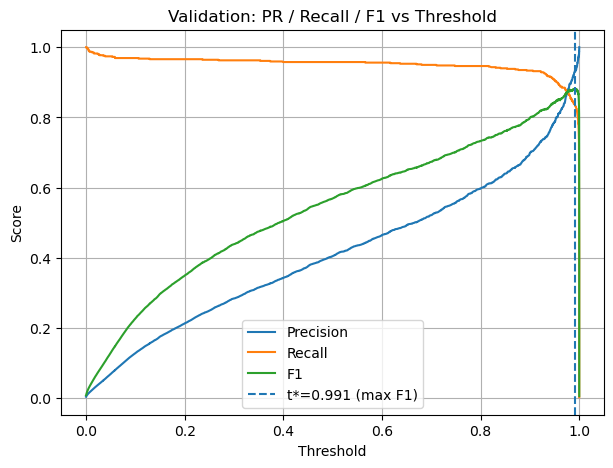

[Validation] t*=0.9912 | F1=0.8828 | Precision=0.9331 | Recall=0.8377


In [89]:
def labels_from_dataset(ds):
    return np.concatenate([y.numpy() for _, y in ds], axis=0).ravel()

# Get validation labels and probabilities
y_va_true = labels_from_dataset(ds_va)
p_va      = model.predict(ds_va, verbose=0).ravel()   # P(class=1 fraud)

prec_va, rec_va, thr_va = precision_recall_curve(y_va_true, p_va)
f1_va = 2 * prec_va * rec_va / (prec_va + rec_va + 1e-8)

best_idx_va = int(np.nanargmax(f1_va))
t_star      = float(thr_va[min(best_idx_va, len(thr_va)-1)])

plt.figure(figsize=(7,5))
plt.plot(thr_va, prec_va[:-1], label='Precision')
plt.plot(thr_va, rec_va[:-1],  label='Recall')
plt.plot(thr_va, f1_va[:-1],   label='F1')
plt.axvline(t_star, ls='--', label=f't*={t_star:.3f} (max F1)')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Validation: PR / Recall / F1 vs Threshold')
plt.grid(True); plt.legend(); plt.show()

print(f"[Validation] t*={t_star:.4f} | "
      f"F1={f1_va[best_idx_va]:.4f} | "
      f"Precision={prec_va[best_idx_va]:.4f} | Recall={rec_va[best_idx_va]:.4f}")


In [90]:
# getting test metrics of for the threshold with the highest f1
y_te_true = labels_from_dataset(ds_te)
p_te      = model.predict(ds_te, verbose=0).ravel()
y_te_pred = (p_te >= t_star).astype(int)

cm = confusion_matrix(y_te_true, y_te_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_te_true, p_te)
ap_te   = average_precision_score(y_te_true, p_te)

print("\n[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_te_true, y_te_pred, digits=4))


[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):
[[136043     53]
 [   113    528]]
TN=136043, FP=53, FN=113, TP=528
Precision=0.9088 | Recall=0.8237 | F1=0.8642 | ROC AUC=0.9953 | PR AUC=0.9235

Classification report:
              precision    recall  f1-score   support

           0     0.9992    0.9996    0.9994    136096
           1     0.9088    0.8237    0.8642       641

    accuracy                         0.9988    136737
   macro avg     0.9540    0.9117    0.9318    136737
weighted avg     0.9987    0.9988    0.9988    136737



In [91]:
# Trying 0.8 threshold
y_te_pred = (p_te >= 0.8).astype(int)

cm = confusion_matrix(y_te_true, y_te_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec_te = tp / (tp + fp + 1e-8)
rec_te  = tp / (tp + fn + 1e-8)
f1_te   = 2 * prec_te * rec_te / (prec_te + rec_te + 1e-8)
roc_te  = roc_auc_score(y_te_true, p_te)
ap_te   = average_precision_score(y_te_true, p_te)

print("\n[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={prec_te:.4f} | Recall={rec_te:.4f} | F1={f1_te:.4f} | "
      f"ROC AUC={roc_te:.4f} | PR AUC={ap_te:.4f}\n")
print("Classification report:")
print(classification_report(y_te_true, y_te_pred, digits=4))


[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):
[[135655    441]
 [    33    608]]
TN=135655, FP=441, FN=33, TP=608
Precision=0.5796 | Recall=0.9485 | F1=0.7195 | ROC AUC=0.9953 | PR AUC=0.9235

Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9968    0.9983    136096
           1     0.5796    0.9485    0.7195       641

    accuracy                         0.9965    136737
   macro avg     0.7897    0.9726    0.8589    136737
weighted avg     0.9978    0.9965    0.9969    136737



In [3]:
import zipfile, json

path = "artifacts_fraud_detec/lstm_fraud_model.keras"  # update if needed
with zipfile.ZipFile(path) as z:
    meta = json.load(z.open("metadata.json"))
print("saved_with_keras =", meta.get("keras_version"))
print(meta)  # optional: see all metadata


saved_with_keras = 3.11.3
{'keras_version': '3.11.3', 'date_saved': '2025-10-15@14:29:07'}


In [2]:
import tensorflow as tf
import keras
import fastapi
import uvicorn
import pydantic
import numpy as np
import pandas as pd
import sklearn
import joblib

print("tensorflow==", tf.__version__)
print("keras==", keras.__version__)
print("fastapi==", fastapi.__version__)
print("uvicorn==", uvicorn.__version__)
print("pydantic==", pydantic.__version__)
print("numpy==", np.__version__)
print("pandas==", pd.__version__)
print("scikit-learn==", sklearn.__version__)
print("joblib==", joblib.__version__)


tensorflow== 2.20.0
keras== 3.11.3
fastapi== 0.119.0
uvicorn== 0.37.0
pydantic== 2.10.3
numpy== 2.1.3
pandas== 2.2.3
scikit-learn== 1.6.1
joblib== 1.4.2
